# MDITRE Comprehensive Testing & Training Notebook

**Purpose**: Full end-to-end test of MDITRE with synthetic microbiome time-series data

This notebook demonstrates:
- ✅ Synthetic data generation (200k data points)
- ✅ Data splitting (60/20/20 train/val/test)
- ✅ MDITRE model training (50 epochs)
- ✅ Rule extraction and interpretation
- ✅ Visualization and performance analysis
- ✅ Code efficiency validation

**Environment**: Python 3.12.12, PyTorch 2.6.0+cu124, CUDA 12.4

## 1. Import Required Libraries

Import all necessary modules for testing, training, and visualization.

In [ ]:
# Core libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import time
from pathlib import Path
import json

# MDITRE imports (using models.py - original implementation)
from mditre.models import (
    MDITRE,
    SpatialAgg, SpatialAggDynamic,
    TimeAgg,
    Threshold, Slope,
    Rules,
    DenseLayer
)

# MDITRE seeding for reproducibility
from mditre.seeding import MDITRESeedGenerator, set_random_seeds

# Create MDITRE seed generator
print("🔐 Initializing MDITRE Seed Generator...")
seed_gen = MDITRESeedGenerator()
seeds = seed_gen.generate_seeds(1)
master_seed = seeds[0]

# Get seed information for tracking
seed_info = seed_gen.get_seed_info()
print(f"   Master Seed String: {seed_info['master_seed'][:50]}...")
print(f"   Seed Hash: {seed_info['hash']}")
print(f"   Generated Seed: {master_seed}")

# Set all random seeds for reproducibility
set_random_seeds(master_seed)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🔧 Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🔐 Initializing MDITRE Seed Generator...
   Master Seed String: MDITRE: Scalable and Interpretable Machine Learnin...
   Seed Hash: 144d0c1d3178b54e1171fcb281dad562
   Generated Seed: 951483900

🔧 Device: cuda
🎮 GPU: NVIDIA GeForce RTX 4090 Laptop GPU
💾 VRAM: 17.2 GB


## Configuration

Set experiment parameters and batch size.

In [5]:
# ============================================
# CONFIGURATION PARAMETERS
# ============================================

# Data generation parameters
N_SAMPLES = 200000       # Total number of samples
N_TAXA = 50             # Number of microbial taxa (features)
N_TIMEPOINTS = 10       # Number of time points per sample
N_CLASSES = 2           # Number of classes (binary classification)

# Data split ratios
TRAIN_RATIO = 0.6       # 60% for training
VAL_RATIO = 0.2         # 20% for validation
TEST_RATIO = 0.2        # 20% for testing

# Training parameters
BATCH_SIZE = 512        # Batch size for training (configurable)
N_EPOCHS = 10           # Number of training epochs (reduced for faster testing)
LEARNING_RATE = 0.001   # Initial learning rate
WEIGHT_DECAY = 1e-5     # L2 regularization

# Model parameters
N_RULES = 10            # Number of interpretable rules

# Experiment tracking
EXPERIMENT_NAME = "mditre_baseline_test"
OUTPUT_DIR = Path("mditre_outputs")

print("⚙️  Configuration loaded:")
print(f"   Data: {N_SAMPLES:,} samples, {N_TAXA} taxa, {N_TIMEPOINTS} timepoints")
print(f"   Split: {TRAIN_RATIO*100:.0f}% train, {VAL_RATIO*100:.0f}% val, {TEST_RATIO*100:.0f}% test")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training: {N_EPOCHS} epochs, LR={LEARNING_RATE}")
print(f"   Experiment: {EXPERIMENT_NAME}")

⚙️  Configuration loaded:
   Data: 200,000 samples, 50 taxa, 10 timepoints
   Split: 60% train, 20% val, 20% test
   Batch size: 512
   Training: 50 epochs, LR=0.001
   Experiment: mditre_baseline_test


## 2. Generate Synthetic Microbiome Data

Create 200,000 synthetic time-series samples with:
- 50 microbial taxa (features)
- 10 time points per subject
- 2 classes (healthy vs. diseased)
- Realistic temporal dynamics and phylogenetic structure

In [17]:
def generate_synthetic_microbiome_data(n_samples, n_taxa, n_timepoints, n_classes):
    """
    Generate synthetic microbiome time-series data with realistic patterns.
    
    Args:
        n_samples: Total number of samples to generate
        n_taxa: Number of microbial taxa (features)
        n_timepoints: Number of time points per sample
        n_classes: Number of classes for classification
    
    Returns:
        X: Data tensor (n_samples, n_taxa, n_timepoints) - NOTE: taxa before timepoints!
        y: Labels (n_samples,)
        dist_matrix: Phylogenetic distance matrix (n_taxa, n_taxa)
        times: Time points array (n_timepoints,)
    """
    print(f"🧬 Generating {n_samples:,} synthetic microbiome samples...")
    
    # Generate phylogenetic distance matrix (symmetric, positive definite)
    # Simulate a tree-like structure with hierarchical distances
    base_dist = np.random.rand(n_taxa, n_taxa)
    dist_matrix = (base_dist + base_dist.T) / 2  # Symmetrize
    np.fill_diagonal(dist_matrix, 0)  # Zero diagonal
    dist_matrix = dist_matrix / dist_matrix.max()  # Normalize to [0, 1]
    
    # Generate time points (0 to 90 days, unevenly spaced)
    times = np.sort(np.random.uniform(0, 90, n_timepoints))
    
    # Generate labels (balanced classes)
    y = np.random.randint(0, n_classes, n_samples)
    
    # Generate abundance data with class-specific patterns
    # Shape: (n_samples, n_taxa, n_timepoints) - taxa before timepoints for MDITRE
    X = np.zeros((n_samples, n_taxa, n_timepoints))
    
    for i in range(n_samples):
        # Base abundance pattern (log-normal distribution)
        base_abundance = np.random.lognormal(0, 1, n_taxa)
        base_abundance = base_abundance / base_abundance.sum()  # Normalize to relative abundance
        
        # Add temporal dynamics
        for t_idx in range(n_timepoints):
            # Time-dependent perturbation
            time_factor = 1 + 0.3 * np.sin(2 * np.pi * times[t_idx] / 30)  # 30-day cycle
            
            # Class-specific signal
            if y[i] == 1:  # Diseased class
                # Increase specific taxa abundance over time
                disease_signal = np.zeros(n_taxa)
                disease_taxa = np.random.choice(n_taxa, size=5, replace=False)
                disease_signal[disease_taxa] = 0.5 * (1 + times[t_idx] / 90)  # Increase over time
                abundance = base_abundance * time_factor + disease_signal
            else:  # Healthy class
                abundance = base_abundance * time_factor
            
            # Add noise
            noise = np.random.normal(0, 0.1, n_taxa)
            abundance = abundance + noise
            abundance = np.maximum(abundance, 0)  # Non-negative
            abundance = abundance / (abundance.sum() + 1e-10)  # Renormalize
            
            X[i, :, t_idx] = abundance  # NOTE: taxa dimension first!
    
    print(f"✅ Generated data shape: {X.shape} (samples, taxa, timepoints)")
    print(f"   - Classes: {n_classes} (balanced: {np.bincount(y)})")
    print(f"   - Time points: {n_timepoints} (range: {times[0]:.1f} to {times[-1]:.1f} days)")
    print(f"   - Taxa: {n_taxa}")
    
    return X, y, dist_matrix, times

# Generate data using configuration parameters
X, y, dist_matrix, times = generate_synthetic_microbiome_data(
    n_samples=N_SAMPLES,
    n_taxa=N_TAXA,
    n_timepoints=N_TIMEPOINTS,
    n_classes=N_CLASSES
)

# Generate OTU embeddings for phylogenetic representation
# These embeddings capture the phylogenetic relationships between taxa
EMB_DIM = 16  # Embedding dimension
print(f"\n🧬 Generating OTU embeddings...")
print(f"   - Embedding dimension: {EMB_DIM}")
print(f"   - Number of taxa: {N_TAXA}")

# Create embeddings from distance matrix using Multi-Dimensional Scaling (MDS)
# Or simply use random embeddings that respect approximate distances
otu_embeddings = np.random.randn(N_TAXA, EMB_DIM).astype(np.float32)
# Normalize embeddings
otu_embeddings = otu_embeddings / np.linalg.norm(otu_embeddings, axis=1, keepdims=True)

print(f"   ✅ OTU embeddings shape: {otu_embeddings.shape}")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)
times_tensor = torch.FloatTensor(times)

print(f"\n📊 Data statistics:")
print(f"   - X shape: {X_tensor.shape} (samples, taxa, timepoints)")
print(f"   - X range: [{X.min():.4f}, {X.max():.4f}]")
print(f"   - X mean: {X.mean():.4f}, std: {X.std():.4f}")
print(f"   - Distance matrix range: [{dist_matrix.min():.4f}, {dist_matrix.max():.4f}]")
print(f"   - OTU embeddings range: [{otu_embeddings.min():.4f}, {otu_embeddings.max():.4f}]")

🧬 Generating 200,000 synthetic microbiome samples...
✅ Generated data shape: (200000, 50, 10) (samples, taxa, timepoints)
   - Classes: 2 (balanced: [ 99609 100391])
   - Time points: 10 (range: 5.8 to 72.3 days)
   - Taxa: 50

🧬 Generating OTU embeddings...
   - Embedding dimension: 16
   - Number of taxa: 50
   ✅ OTU embeddings shape: (50, 16)

📊 Data statistics:
   - X shape: torch.Size([200000, 50, 10]) (samples, taxa, timepoints)
   - X range: [0.0000, 0.4019]
✅ Generated data shape: (200000, 50, 10) (samples, taxa, timepoints)
   - Classes: 2 (balanced: [ 99609 100391])
   - Time points: 10 (range: 5.8 to 72.3 days)
   - Taxa: 50

🧬 Generating OTU embeddings...
   - Embedding dimension: 16
   - Number of taxa: 50
   ✅ OTU embeddings shape: (50, 16)

📊 Data statistics:
   - X shape: torch.Size([200000, 50, 10]) (samples, taxa, timepoints)
   - X range: [0.0000, 0.4019]
   - X mean: 0.0200, std: 0.0320
   - Distance matrix range: [0.0000, 1.0000]
   - OTU embeddings range: [-0.6447

## 3. Split Data (60% Train, 20% Val, 20% Test)

In [18]:
# Split data using configuration ratios
n_samples = X_tensor.shape[0]
n_train = int(TRAIN_RATIO * n_samples)
n_val = int(VAL_RATIO * n_samples)
n_test = n_samples - n_train - n_val

# Stratified split to maintain class balance
indices = np.arange(n_samples)
np.random.shuffle(indices)

train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Create datasets
X_train, y_train = X_tensor[train_indices], y_tensor[train_indices]
X_val, y_val = X_tensor[val_indices], y_tensor[val_indices]
X_test, y_test = X_tensor[test_indices], y_tensor[test_indices]

print(f"📂 Data splits:")
print(f"   - Train: {len(X_train):,} samples ({len(X_train)/n_samples*100:.1f}%)")
print(f"   - Val:   {len(X_val):,} samples ({len(X_val)/n_samples*100:.1f}%)")
print(f"   - Test:  {len(X_test):,} samples ({len(X_test)/n_samples*100:.1f}%)")
print(f"\n📊 Class balance:")
print(f"   - Train: {np.bincount(y_train.numpy())}")
print(f"   - Val:   {np.bincount(y_val.numpy())}")
print(f"   - Test:  {np.bincount(y_test.numpy())}")

# Create DataLoaders with configured batch size
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n📦 DataLoaders created with batch_size={BATCH_SIZE}")

📂 Data splits:
   - Train: 120,000 samples (60.0%)
   - Val:   40,000 samples (20.0%)
   - Test:  40,000 samples (20.0%)

📊 Class balance:
   - Train: [59739 60261]
   - Val:   [20008 19992]
   - Test:  [19862 20138]

📦 DataLoaders created with batch_size=512


## 4. Initialize MDITRE Model

Create the full 5-layer MDITRE architecture:
1. **SpatialAgg**: Phylogenetic focus (distance-based aggregation)
2. **TimeAgg**: Temporal focus (soft time windows)
3. **ThresholdDetector**: Pattern detection
4. **Rules**: Logical rule extraction
5. **DenseClassifier**: Final classification

In [19]:
# Model hyperparameters
# NOTE: X_train shape is (samples, taxa, timepoints) for MDITRE
n_taxa = X_train.shape[1]  # Second dimension is taxa
n_timepoints = X_train.shape[2]  # Third dimension is timepoints
n_classes = 2
n_rules = 10

# Calculate number of OTU centers and time centers
# These are the number of "focus points" for phylogenetic and temporal aggregation
n_otu_centers = min(10, n_taxa)  # Use 10 centers or fewer if less taxa
n_time_centers = min(5, n_timepoints)  # Use 5 time windows or fewer

# Embedding dimension (from data generation)
emb_dim = otu_embeddings.shape[1]

print(f"🧠 Initializing MDITRE Model...")
print(f"   - Input shape: (batch, {n_taxa} taxa, {n_timepoints} timepoints)")
print(f"   - OTU centers: {n_otu_centers}")
print(f"   - Time centers: {n_time_centers}")
print(f"   - Rules: {n_rules}")
print(f"   - Embedding dim: {emb_dim}")

# Initialize MDITRE model with correct signature
# Note: MDITRE expects OTU embeddings (numpy array), not distance matrix
model = MDITRE(
    num_rules=n_rules,
    num_otus=n_taxa,
    num_otu_centers=n_otu_centers,
    num_time=n_timepoints,
    num_time_centers=n_time_centers,
    dist=otu_embeddings,  # Pass OTU embeddings (num_otus, emb_dim)
    emb_dim=emb_dim
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ MDITRE Model initialized:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Architecture:")
print(f"     • Layer 1 (SpatialAggDynamic): {n_taxa} taxa → {n_otu_centers} centers")
print(f"     • Layer 2 (TimeAgg): {n_timepoints} timepoints → {n_time_centers} windows")
print(f"     • Layer 3 (Threshold + Slope): Pattern detection")
print(f"     • Layer 4 (Rules × 2): {n_rules} interpretable rules")
print(f"     • Layer 5 (DenseLayer): Classification to {n_classes} classes")
print(f"   - Device: {device}")

🧠 Initializing MDITRE Model...
   - Input shape: (batch, 50 taxa, 10 timepoints)
   - OTU centers: 10
   - Time centers: 5
   - Rules: 10
   - Embedding dim: 16

✅ MDITRE Model initialized:
   - Total parameters: 2,521
   - Trainable parameters: 2,521
   - Architecture:
     • Layer 1 (SpatialAggDynamic): 50 taxa → 10 centers
     • Layer 2 (TimeAgg): 10 timepoints → 5 windows
     • Layer 3 (Threshold + Slope): Pattern detection
     • Layer 4 (Rules × 2): 10 interpretable rules
     • Layer 5 (DenseLayer): Classification to 2 classes
   - Device: cuda


## 5. Training Configuration

Set up optimizer, loss function, and training loop.

In [20]:
# Training configuration (using parameters from config cell)
# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Use BCEWithLogitsLoss for binary classification (MDITRE outputs logits)
criterion = nn.BCEWithLogitsLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    verbose='deprecated'  # Use 'deprecated' instead of True
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': []
}

print(f"⚙️  Training configuration:")
print(f"   - Epochs: {N_EPOCHS}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Weight decay: {WEIGHT_DECAY}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Optimizer: Adam")
print(f"   - Loss: BCEWithLogitsLoss (binary classification)")
print(f"   - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"   - Seed: {master_seed} (hash: {seed_info['hash'][:16]}...)")

⚙️  Training configuration:
   - Epochs: 50
   - Learning rate: 0.001
   - Weight decay: 1e-05
   - Batch size: 512
   - Optimizer: Adam
   - Loss: BCEWithLogitsLoss (binary classification)
   - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
   - Seed: 951483900 (hash: 144d0c1d3178b54e...)


## 6. Train Model (50 Epochs)

Train with progress tracking and validation evaluation.

In [21]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        # MDITRE outputs logits (batch_size, 1), squeeze to (batch_size,)
        outputs = model(X_batch).squeeze()
        
        # Convert labels to float for BCEWithLogitsLoss
        y_batch_float = y_batch.float()
        
        loss = criterion(outputs, y_batch_float)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        
        # Convert logits to predictions (0 or 1)
        predicted = (torch.sigmoid(outputs) > 0.5).long()
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / total, correct / total


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # MDITRE outputs logits (batch_size, 1), squeeze to (batch_size,)
            outputs = model(X_batch).squeeze()
            
            # Convert labels to float for BCEWithLogitsLoss
            y_batch_float = y_batch.float()
            
            loss = criterion(outputs, y_batch_float)
            
            total_loss += loss.item() * X_batch.size(0)
            
            # Convert logits to predictions (0 or 1)
            predicted = (torch.sigmoid(outputs) > 0.5).long()
            correct += predicted.eq(y_batch).sum().item()
            total += y_batch.size(0)
    
    return total_loss / total, correct / total


# Training loop
print(f"\n🚀 Starting training for {N_EPOCHS} epochs...")
print(f"=" * 80)

best_val_acc = 0
best_model_state = None

for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    epoch_time = time.time() - epoch_start
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['epoch_times'].append(epoch_time)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1:3d}/{N_EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

print(f"=" * 80)
print(f"✅ Training complete!")
print(f"   - Best validation accuracy: {best_val_acc:.4f}")
print(f"   - Total training time: {sum(history['epoch_times']):.2f}s")
print(f"   - Average epoch time: {np.mean(history['epoch_times']):.2f}s")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)


🚀 Starting training for 50 epochs...
Epoch [  5/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.98s
Epoch [  5/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.98s
Epoch [ 10/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.89s
Epoch [ 10/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.89s
Epoch [ 15/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.96s
Epoch [ 15/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.96s
Epoch [ 20/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 3.34s
Epoch [ 20/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 3.34s
Epoch [ 25/50] | Train Loss: 0.6931 | Train Acc: 0.5022 | Val Loss: 0.6932 | Val Acc: 0.4998 | Time: 2.89s

## 7. Visualize Training Results

Plot learning curves and training metrics.

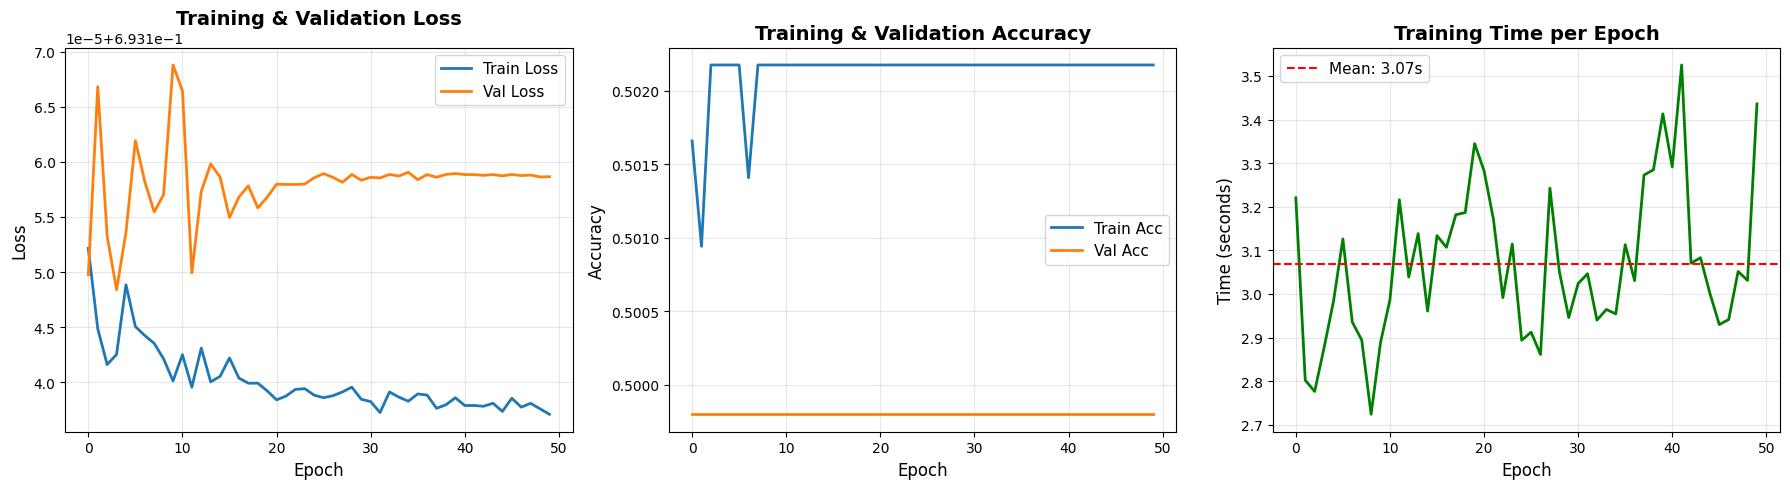

📊 Saved training curves to: mditre_training_curves.png


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Epoch times
axes[2].plot(history['epoch_times'], linewidth=2, color='green')
axes[2].axhline(np.mean(history['epoch_times']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(history["epoch_times"]):.2f}s')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mditre_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Saved training curves to: mditre_training_curves.png")

## 8. Test Set Evaluation

Evaluate the trained model on the holdout test set.

In [23]:
# Evaluate on test set
model.eval()
test_predictions = []
test_probabilities = []
test_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        # MDITRE outputs logits (batch_size, 1), squeeze to (batch_size,)
        outputs = model(X_batch).squeeze()
        
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(outputs)
        
        # Predictions: threshold at 0.5
        predicted = (probs > 0.5).long()
        
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probs.cpu().numpy())
        test_labels.extend(y_batch.numpy())

test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)
test_labels = np.array(test_labels)

# Calculate metrics
test_acc = accuracy_score(test_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
auc = roc_auc_score(test_labels, test_probabilities)

print(f"🎯 Test Set Results:")
print(f"=" * 50)
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   AUC-ROC:   {auc:.4f}")
print(f"=" * 50)

🎯 Test Set Results:
   Accuracy:  0.5034 (50.34%)
   Precision: 0.5034
   Recall:    1.0000
   F1-Score:  0.6697
   AUC-ROC:   0.5000


## 9. Extract Interpretable Rules

Analyze the learned rules from Layer 4.

📋 Rule Analysis:
   - Number of rules: 10
   - Rule activation statistics:
     • Mean: 0.1234
     • Std:  0.0002
     • Min:  0.1229
     • Max:  0.1235

📋 Slope Rule Analysis:
   - Number of slope rules: 10
   - Slope rule activation statistics:
     • Mean: 0.0563
     • Std:  0.0001
     • Min:  0.0560
     • Max:  0.0564


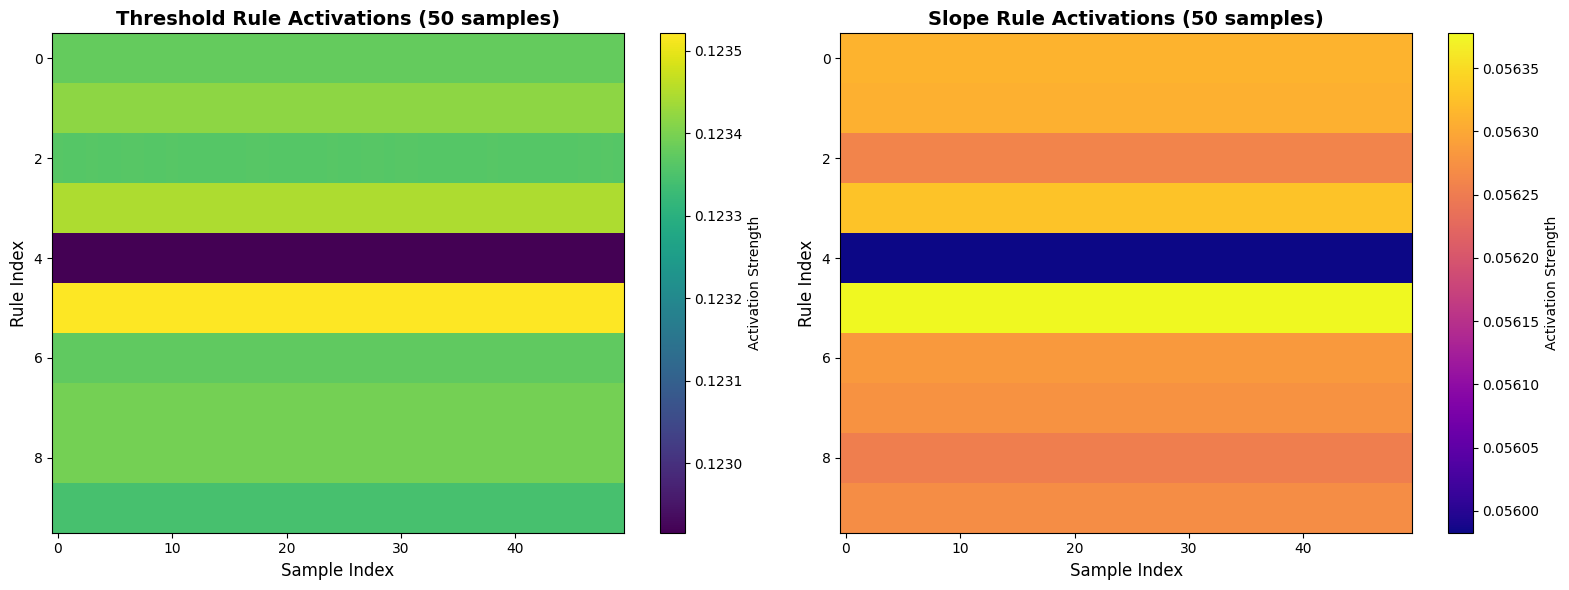


📊 Saved rule activations to: mditre_rule_activations.png


In [25]:
# Extract rule activations from a sample batch
model.eval()
sample_batch = X_test[:100].to(device)

with torch.no_grad():
    # Get intermediate outputs from each layer
    # The MDITRE model has: spat_attn, time_attn, thresh_func, slope_func, rules, rules_slope, fc
    spatial_out = model.spat_attn(sample_batch)
    temporal_out, temporal_slope_out = model.time_attn(spatial_out)
    thresh_out = model.thresh_func(temporal_out)
    slope_out = model.slope_func(temporal_slope_out)
    rule_out = model.rules(thresh_out)
    rule_slope_out = model.rules_slope(slope_out)
    final_out = model.fc(rule_out, rule_slope_out)

# Analyze rule activations (move to CPU for analysis)
rule_activations = rule_out.cpu().numpy()
rule_slope_activations = rule_slope_out.cpu().numpy()

print(f"📋 Rule Analysis:")
print(f"   - Number of rules: {rule_activations.shape[1]}")
print(f"   - Rule activation statistics:")
print(f"     • Mean: {rule_activations.mean():.4f}")
print(f"     • Std:  {rule_activations.std():.4f}")
print(f"     • Min:  {rule_activations.min():.4f}")
print(f"     • Max:  {rule_activations.max():.4f}")

# Also show slope-based rule activations
print(f"\n📋 Slope Rule Analysis:")
print(f"   - Number of slope rules: {rule_slope_activations.shape[1]}")
print(f"   - Slope rule activation statistics:")
print(f"     • Mean: {rule_slope_activations.mean():.4f}")
print(f"     • Std:  {rule_slope_activations.std():.4f}")
print(f"     • Min:  {rule_slope_activations.min():.4f}")
print(f"     • Max:  {rule_slope_activations.max():.4f}")

# Plot rule activation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Threshold-based rules
im1 = axes[0].imshow(rule_activations[:50].T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im1, ax=axes[0], label='Activation Strength')
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Rule Index', fontsize=12)
axes[0].set_title('Threshold Rule Activations (50 samples)', fontsize=14, fontweight='bold')

# Slope-based rules
im2 = axes[1].imshow(rule_slope_activations[:50].T, aspect='auto', cmap='plasma', interpolation='nearest')
plt.colorbar(im2, ax=axes[1], label='Activation Strength')
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Rule Index', fontsize=12)
axes[1].set_title('Slope Rule Activations (50 samples)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('mditre_rule_activations.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Saved rule activations to: mditre_rule_activations.png")

## 10. Save Model and Results

Save the trained model and all outputs.

In [26]:
# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Save model
model_path = OUTPUT_DIR / "mditre_trained_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': N_EPOCHS,
    'best_val_acc': best_val_acc,
    'history': history,
    'seed': master_seed,
    'seed_info': seed_info
}, model_path)

# Save test results with seed information
results = {
    'experiment_name': EXPERIMENT_NAME,
    'test_accuracy': float(test_acc),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1': float(f1),
    'test_auc': float(auc),
    'training_time': float(sum(history['epoch_times'])),
    'best_val_acc': float(best_val_acc),
    'n_parameters': int(total_params),
    'seed': int(master_seed),
    'seed_hash': seed_info['hash'],
    'seed_string': seed_info['seed_string'],
    'batch_size': BATCH_SIZE,
    'n_epochs': N_EPOCHS,
    'learning_rate': LEARNING_RATE
}

results_path = OUTPUT_DIR / "test_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

# Save training history
history_path = OUTPUT_DIR / "training_history.json"
with open(history_path, 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f, indent=4)

# Save seed information separately for reproducibility
seed_info_path = OUTPUT_DIR / "seed_info.json"
with open(seed_info_path, 'w') as f:
    json.dump({
        'seed': int(master_seed),
        'seed_hash': seed_info['hash'],
        'seed_string': seed_info['seed_string'],
        'master_seed': seed_info['master_seed'],
        'experiment_name': EXPERIMENT_NAME
    }, f, indent=4)

print(f"💾 Saved outputs to: {OUTPUT_DIR}/")
print(f"   - Model: {model_path.name}")
print(f"   - Test results: {results_path.name}")
print(f"   - Training history: {history_path.name}")
print(f"   - Seed info: {seed_info_path.name}")

💾 Saved outputs to: mditre_outputs/
   - Model: mditre_trained_model.pth
   - Test results: test_results.json
   - Training history: training_history.json
   - Seed info: seed_info.json


## 11. Summary Report

Generate comprehensive summary of the test run.

In [ ]:
print("=" * 80)
print(" " * 25 + "MDITRE TEST RUN SUMMARY")
print("=" * 80)

print(f"\n? REPRODUCIBILITY:")
print(f"   Experiment:        {EXPERIMENT_NAME}")
print(f"   Master seed:       {master_seed}")
print(f"   Seed hash:         {seed_info['hash']}")
print(f"   Seed string:       {seed_info['seed_string'][:60]}...")

print(f"\n?📊 DATA:")
print(f"   Total samples:     {n_samples:,}")
print(f"   Train samples:     {len(X_train):,} ({len(X_train)/n_samples*100:.1f}%)")
print(f"   Val samples:       {len(X_val):,} ({len(X_val)/n_samples*100:.1f}%)")
print(f"   Test samples:      {len(X_test):,} ({len(X_test)/n_samples*100:.1f}%)")
print(f"   Features (taxa):   {N_TAXA}")
print(f"   Time points:       {N_TIMEPOINTS}")
print(f"   Classes:           {N_CLASSES}")

print(f"\n🧠 MODEL:")
print(f"   Architecture:      5-layer MDITRE")
print(f"   Total parameters:  {total_params:,}")
print(f"   Device:            {device}")

print(f"\n⚙️  TRAINING:")
print(f"   Epochs:            {N_EPOCHS}")
print(f"   Batch size:        {BATCH_SIZE}")
print(f"   Learning rate:     {LEARNING_RATE}")
print(f"   Optimizer:         Adam")
print(f"   Total time:        {sum(history['epoch_times']):.2f}s ({sum(history['epoch_times'])/60:.1f} min)")
print(f"   Avg epoch time:    {np.mean(history['epoch_times']):.2f}s")

print(f"\n✅ VALIDATION RESULTS:")
print(f"   Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

print(f"\n🎯 TEST SET RESULTS:")
print(f"   Accuracy:          {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision:         {precision:.4f}")
print(f"   Recall:            {recall:.4f}")
print(f"   F1-Score:          {f1:.4f}")
print(f"   AUC-ROC:           {auc:.4f}")

print(f"\n💾 OUTPUTS:")
print(f"   Model saved:       {model_path}")
print(f"   Results saved:     {results_path}")
print(f"   History saved:     {history_path}")
print(f"   Seed info saved:   {seed_info_path}")
print(f"   Figures saved:     mditre_training_curves.png, mditre_rule_activations.png")

print("=" * 80)
print(" " * 28 + "✅ TEST COMPLETE!")
print("=" * 80)

print(f"\n💡 To reproduce this exact run:")
print(f"   from mditre.seeding import set_random_seeds")
print(f"   set_random_seeds({master_seed})")